In [1]:
import pandas as pd
import torch
import json
import os
import argparse
import random
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import gzip
from pprint import pprint
from scipy.stats import ttest_ind
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import KMeans
from sklearn import manifold


import data
import data_config

import warnings
warnings.filterwarnings("ignore")

/Users/hedi/.conda/envs/pytorch/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.bicluster module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


In [3]:
def reverse_rankdata(a):
    return rankdata([-1 * i for i in a]).astype(int)

def generate_p_val(a, b):
    t, p = ttest_ind(a, b, equal_var=False)
    print("ttest_ind:            t = %g  p = %g" % (t, p))

## Ablation Study 

In [4]:
def build_ablation_plot_df(mean_val_df, drug_list, pdtc_flag=False, by='adsn_norm'):
    method_dict = {
               'ndsn':"code-ae-base*", 
               'mdsn': 'code-ae-mmd*', 
               'adsn': 'code-ae-adv*',
               'ndsn_concat':"code-ae-base(concat)*", 
               'mdsn_concat': 'code-ae-mmd(concat)*', 
               'adsn_concat': 'code-ae-adv(concat)*',
               'ndsn_norm_concat':"code-ae-base(concat)", 
               'mdsn_norm_concat': 'code-ae-mmd(concat)', 
               'adsn_norm_concat': 'code-ae-adv(concat)',
               'ndsn_norm':"code-ae-base", 
               'mdsn_norm': 'code-ae-mmd', 
               'adsn_norm': 'code-ae-adv'
              }
    if pdtc_flag:
        drug_mapping_df = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0)
    else:
        drug_mapping_df = pd.read_csv(data_config.gdsc_tcga_mapping_file, index_col=0)
        
    drug_dict = drug_mapping_df['gdsc_name'].to_dict()
    
    mean_val_df = mean_val_df[drug_list]
    drug_order = mean_val_df.transpose().sort_values(by, ascending=False).index.to_list()
    drug_order = [drug_dict[drug] for drug in drug_order]
    
    mean_val_df = mean_val_df.rename(index=method_dict)
    mean_val_df = mean_val_df.rename(index={k: k.upper() for k in mean_val_df.index})
    mean_val_df = mean_val_df.rename(columns=drug_dict)
    mean_val_df = mean_val_df.stack().rename('mean_val')
        
    plot_df = mean_val_df.to_frame().reset_index().rename(columns={'level_0':'method', 'level_1':'drug'})
    plot_df['normalization'] = ['NO' if flag else 'YES' for flag in plot_df.method.str.contains('\*')]
    plot_df.loc[plot_df.normalization == 'NO', 'method'] = plot_df.loc[plot_df.normalization == 'NO', 'method'].str[:-1]

            
    method_order = ['CODE-AE-ADV','CODE-AE-ADV(CONCAT)', 'CODE-AE-BASE','CODE-AE-BASE(CONCAT)','CODE-AE-MMD','CODE-AE-MMD(CONCAT)']
    plot_df.method = plot_df.method.astype('category')
    plot_df.method.cat.set_categories(method_order, inplace=True)
    plot_df.sort_values(by='method', inplace=True)
    
    plot_df.drug = plot_df.drug.astype('category')
    plot_df.drug.cat.set_categories(drug_order, inplace=True)
    plot_df.sort_values(by='drug', inplace=True)


    
    return plot_df

    

In [5]:
pdtc_drug_list = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0).index.tolist()
pdtc_auc_ft_report = pd.read_csv('../intermediate_results/plot_data/ablation_pdtc_auc_ft_mean.csv', index_col=0)
pdtc_auc_ft_report_std = pd.read_csv('../intermediate_results/plot_data/ablation_pdtc_auc_ft_std.csv',index_col=0)
ablation_pdtc_plot_df = build_ablation_plot_df(mean_val_df=pdtc_auc_ft_report,
                             drug_list = pdtc_drug_list,
                             pdtc_flag=True,
                             by='adsn_norm'
)

In [6]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)

method
ndsn                9.02
mdsn                6.32
adsn                3.80
ndsn_norm           6.34
mdsn_norm           7.08
adsn_norm           1.70
ndsn_concat         9.20
mdsn_concat         6.90
adsn_concat         4.40
ndsn_norm_concat    7.52
mdsn_norm_concat    8.70
adsn_norm_concat    6.50
dtype: float64

In [7]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)

method
ndsn                2.217647
mdsn                2.645288
adsn                2.222336
ndsn_norm           3.255200
mdsn_norm           3.911469
adsn_norm           1.265718
ndsn_concat         2.515260
mdsn_concat         2.501020
adsn_concat         2.579353
ndsn_norm_concat    3.418079
mdsn_norm_concat    2.620562
adsn_norm_concat    2.764572
dtype: float64

In [8]:
palette ={
    'CODE-AE-BASE':'yellow', 
    'CODE-AE-MMD':'blue',
    'CODE-AE-ADV':'red',
    'CODE-AE-BASE(CONCAT)':'green', 
    'CODE-AE-MMD(CONCAT)':'purple',
    'CODE-AE-ADV(CONCAT)':'black'}

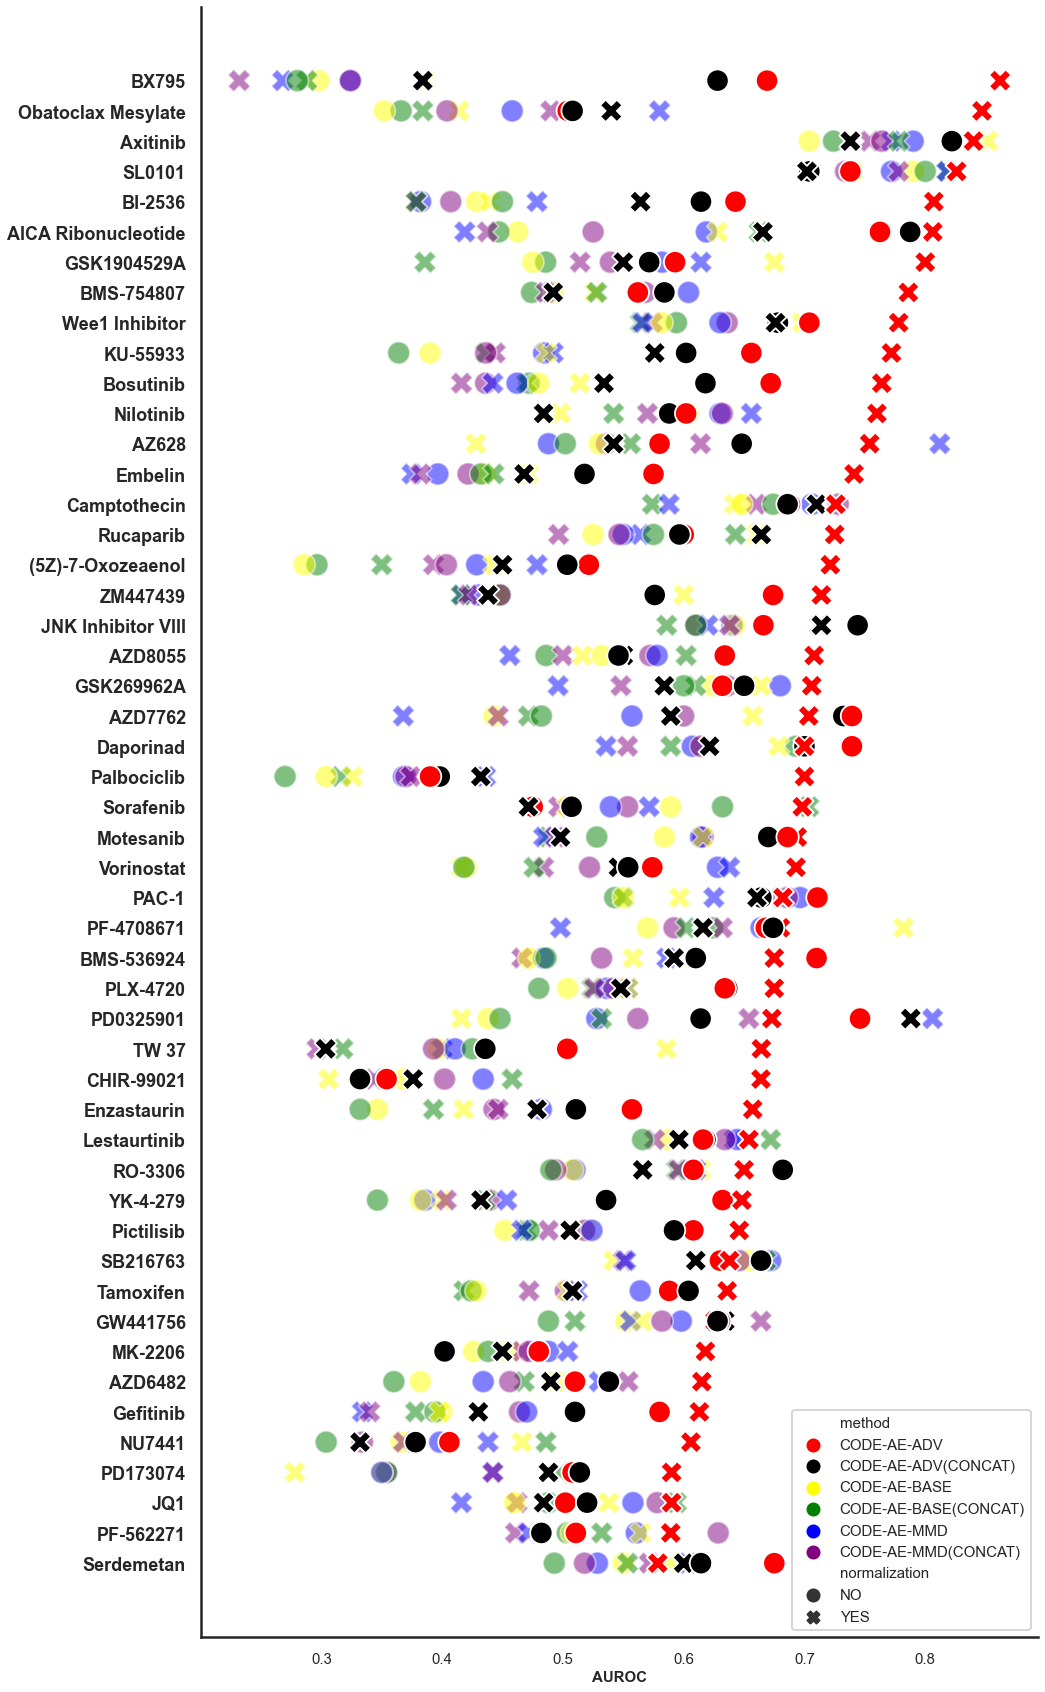

In [9]:
plt.figure(figsize=(15, 30))
sns.set(style='white', context='poster')
ax = sns.scatterplot(x='mean_val', y='drug', hue='method', style='normalization',
                     alpha=0.5,
                     s=500,
                     palette=palette,
                     data=ablation_pdtc_plot_df[ablation_pdtc_plot_df.method.isin(['CODE-AE-MMD','CODE-AE-BASE','CODE-AE-BASE(CONCAT)','CODE-AE-MMD(CONCAT)'])],
                    legend=False)
sns.scatterplot(x='mean_val', y='drug', hue='method', style='normalization',
                alpha=1.0,
                s=500,
                palette=palette,
                data=ablation_pdtc_plot_df[ablation_pdtc_plot_df.method.str.contains('CODE-AE-ADV')]
               )

sns.despine()
plt.ylabel('')
plt.xlabel('AUROC', fontsize=15, weight='bold')
plt.yticks(fontsize=18, weight='bold')
plt.xticks(fontsize=15)
plt.legend(loc='lower right', fontsize=15)
#plt.savefig('../paper/ablation_pdtc_auc.png', format='png', dpi=350,bbox_inches='tight')

## PDTC study result

In [10]:
def build_plot_df(mean_val_df, std_val_df, drug_list, pdtc_flag=False, by='adsn_norm'):
    method_dict = {'tcrp': 'tcrp',
                   'cell_enet':'celligner',
               'dsn':"dsn-mmd", 
               'dsna': 'dsn-dann', 
               'adsn_norm': 'code-ae-adv'
              }

    if pdtc_flag:
        drug_mapping_df = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0)
    else:
        drug_mapping_df = pd.read_csv(data_config.gdsc_tcga_mapping_file, index_col=0)
        
    drug_dict = drug_mapping_df['gdsc_name'].to_dict()
    
    mean_val_df = mean_val_df[drug_list]
    drug_order = mean_val_df.transpose().sort_values(by, ascending=False).index.to_list()
    drug_order = [drug_dict[drug] for drug in drug_order]
    
    mean_val_df = mean_val_df.rename(index=method_dict)
    mean_val_df = mean_val_df.rename(index={k: k.upper() for k in mean_val_df.index})
    mean_val_df = mean_val_df.rename(columns=drug_dict)
    mean_val_df = mean_val_df.stack().rename('mean_val')
    
    std_val_df = std_val_df[drug_list].rename(index=method_dict)
    std_val_df = std_val_df.rename(index={k: k.upper() for k in std_val_df.index})
    std_val_df = std_val_df.rename(columns=drug_dict)
    std_val_df = std_val_df.stack().rename('s.d.')
    std_val_df = pd.cut(std_val_df,
       [0,0.01,0.10,1.0], 
       labels=["<0.01", "0.01-0.10",'>0.10'],
       include_lowest=True,
      )
    std_val_df = std_val_df.cat.set_categories(reversed(std_val_df.cat.categories))
    
    plot_df = mean_val_df.to_frame().join(std_val_df).reset_index().rename(columns={'level_0':'method', 'level_1':'drug'})
    
    plot_df.drug = plot_df.drug.astype('category')
    plot_df.drug.cat.set_categories(drug_order, inplace=True)
    plot_df.sort_values(by='drug', inplace=True)
    
    method_order = ['RF','ENET', 'MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN', 'COXRF','CELLIGNER','ADAE','CODE-AE-ADV']
    plot_df.method = plot_df.method.astype('category')
    plot_df.method.cat.set_categories(method_order, inplace=True)
    plot_df.sort_values(by='method', inplace=True)
    
    plot_df['pre_training'] = 'YES'
    plot_df.loc[plot_df.method.isin(['RF', 'ENET','MLP','TCRP']), 'pre_training']='NO'

    
    return plot_df

    

In [11]:
pdtc_auc_ft_report = pd.read_csv('../intermediate_results/plot_data/pdtc_auc_ft_mean.csv', index_col=0)
pdtc_auc_ft_report_std = pd.read_csv('../intermediate_results/plot_data/pdtc_auc_ft_std.csv',index_col=0)
pdtc_plot_df = build_plot_df(mean_val_df=pdtc_auc_ft_report,
                             std_val_df=pdtc_auc_ft_report_std,
                             drug_list = pdtc_drug_list,
                             pdtc_flag=True,
                             by='adsn_norm'
)

In [12]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)

method
cell_enet    11.58
enet         12.94
rf           13.72
mlp          13.56
ae            9.28
dae           9.32
vae           4.24
vaen          6.32
coral         8.48
adae          4.02
tcrp         11.80
dsna          7.52
coxen         7.54
coxerf        7.48
dsn           5.74
adsn_norm     2.08
dtype: float64

In [13]:
pdtc_auc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)

method
cell_enet    3.796292
enet         2.902567
rf           2.050784
mlp          2.130057
ae           3.175416
dae          2.668333
vae          2.630744
vaen         2.728833
coral        2.865986
adae         1.900483
tcrp         3.003399
dsna         2.628261
coxen        5.163490
coxerf       4.883291
dsn          3.281426
adsn_norm    1.352850
dtype: float64

In [14]:
palette ={
    'ENET':'mediumpurple', 
    'RF':'rebeccapurple',
    'MLP':'purple', 
    'AE':'palegreen',
    'DAE':'limegreen',
    'VAE':'seagreen',
    'VAEN': 'darkgreen',
    'CORAL':'orange',
    'ADAE':'blue', 
    'COXEN':'lightgray',
    'COXRF':'darkgray',
    'CELLIGNER':'darkslategray',
    'DSN-MMD':'gold',
    'DSN-DANN':'yellow', 
    'TCRP':'black',
    'CODE-AE-ADV':'red'}

marker_dict = {
    'ENET':'s', 
    'RF':'s',
    'MLP':'s', 
    'AE':'P',
    'DAE':'P',
    'VAE':'P',
    'VAEN': 'P',
    'CORAL':'H',
    'ADAE':'H', 
    'COXEN':'X',
    'COXRF':'X',
    'CELLIGNER':'X',
    'DSN-MMD':'D',
    'DSN-DANN':'D', 
    'TCRP':'s',
    'CODE-AE-ADV':'o'
}

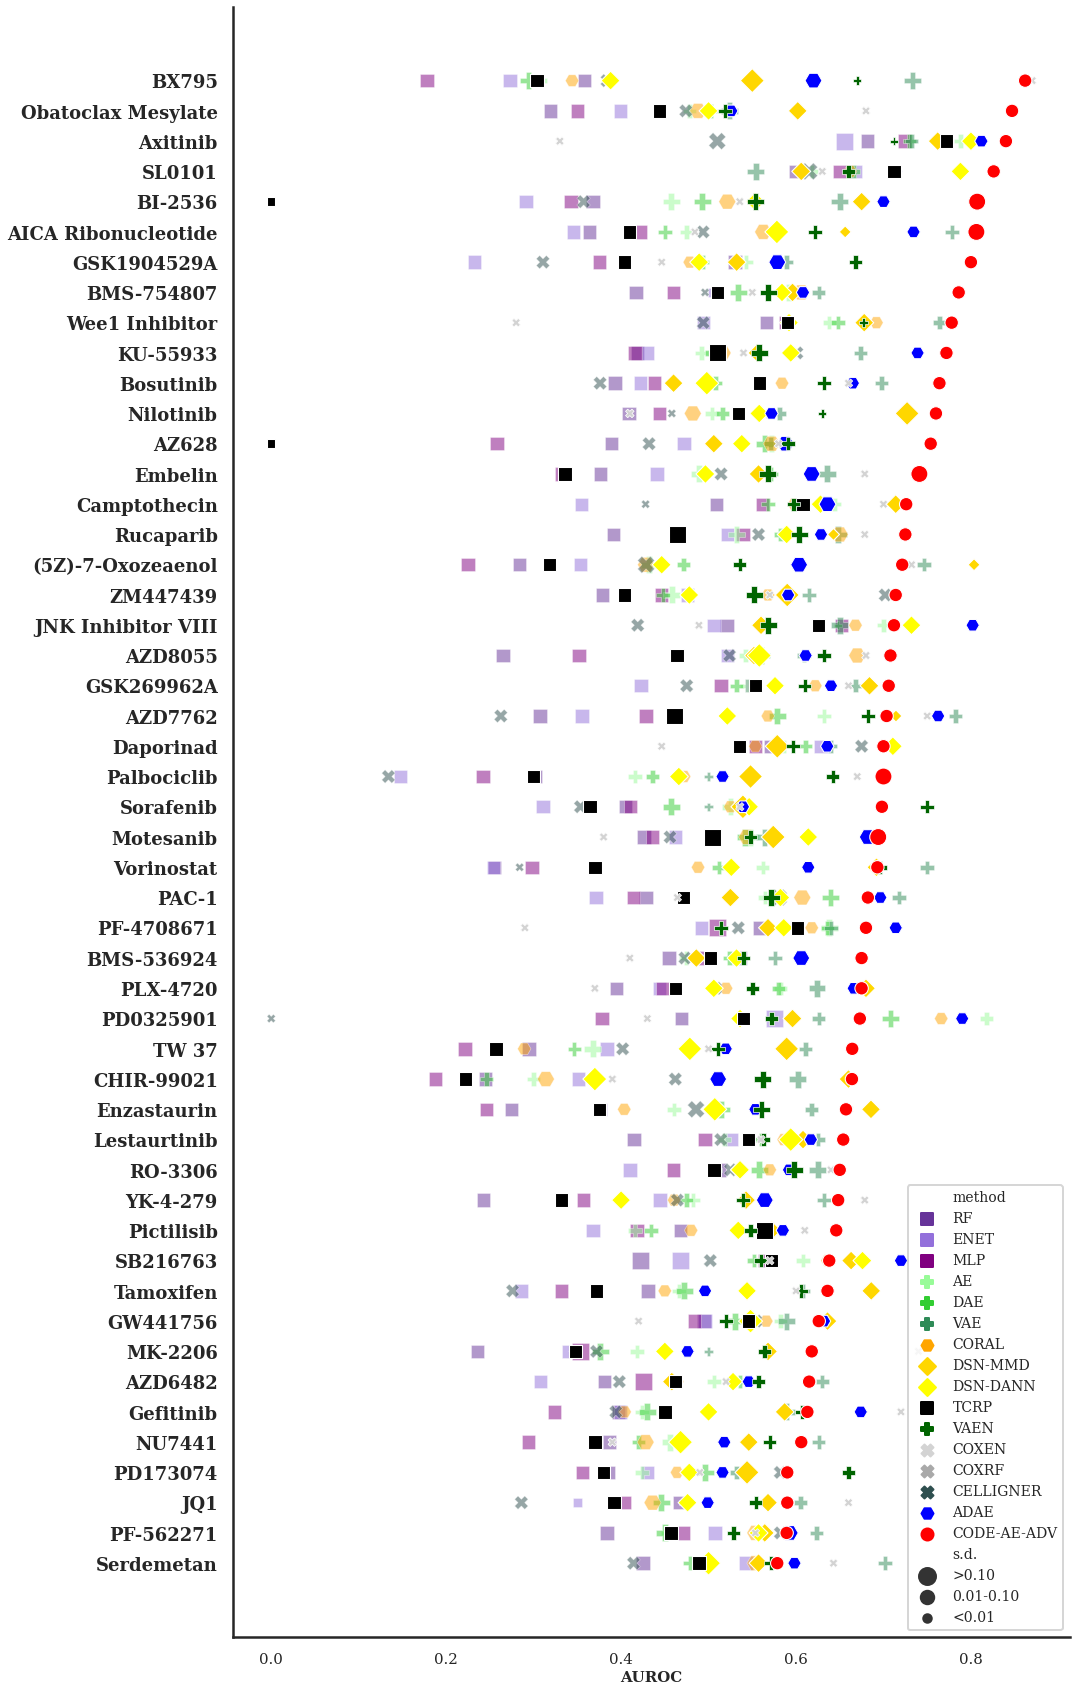

In [15]:
plt.figure(figsize=(15, 30))
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})
ax = sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                     alpha=0.5,
                     s=500,
                     palette=palette,
                     data=pdtc_plot_df[~pdtc_plot_df.method.isin(['CODE-AE-ADV', 'TCRP','VAEN','DSN-MMD','DSN-DANN','ADAE'])],
                    legend=True)
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['DSN-MMD','DSN-DANN','ADAE'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['TCRP'])],
                legend=False
               )
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['VAEN', 'COXEN', 'COXRF'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['CODE-AE-ADV'])],
                legend=False
               )


sns.despine()
plt.ylabel('')
plt.xlabel('AUROC', fontsize=15, weight='bold')
plt.yticks(fontsize=18, weight='bold')
plt.xticks(fontsize=15)
plt.legend(loc='lower right', fontsize=14)
#plt.savefig('../paper/pdtc_auc.png', format='png', dpi=350,bbox_inches='tight')

### AUPRC

In [16]:
pdtc_auprc_ft_report = pd.read_csv('../intermediate_results/plot_data/pdtc_auprc_ft_mean.csv', index_col=0)
pdtc_auprc_ft_report_std = pd.read_csv('../intermediate_results/plot_data/pdtc_auprc_ft_std.csv',index_col=0)
pdtc_plot_df = build_plot_df(mean_val_df=pdtc_auprc_ft_report,
                             std_val_df=pdtc_auprc_ft_report_std,
                             drug_list = pdtc_drug_list,
                             pdtc_flag=True,
                             by='adsn_norm'
)

In [17]:
pdtc_auprc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)

method
cell_enet    10.42
enet         10.40
rf           14.14
mlp          14.02
ae           10.02
dae           9.76
vae           2.60
vaen          2.44
coral         9.52
adae          3.94
tcrp         12.24
dsna          8.70
coxen         8.24
coxrf         8.08
dsn           8.80
adsn_norm     2.28
dtype: float64

In [18]:
pdtc_auprc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)

method
cell_enet    4.046112
enet         3.822597
rf           2.147709
mlp          1.597064
ae           2.567378
dae          2.511687
vae          1.428571
vaen         1.387407
coral        2.801166
adae         1.683170
tcrp         2.832465
dsna         2.565469
coxen        4.456410
coxrf        3.932284
dsn          3.077237
adsn_norm    1.525832
dtype: float64

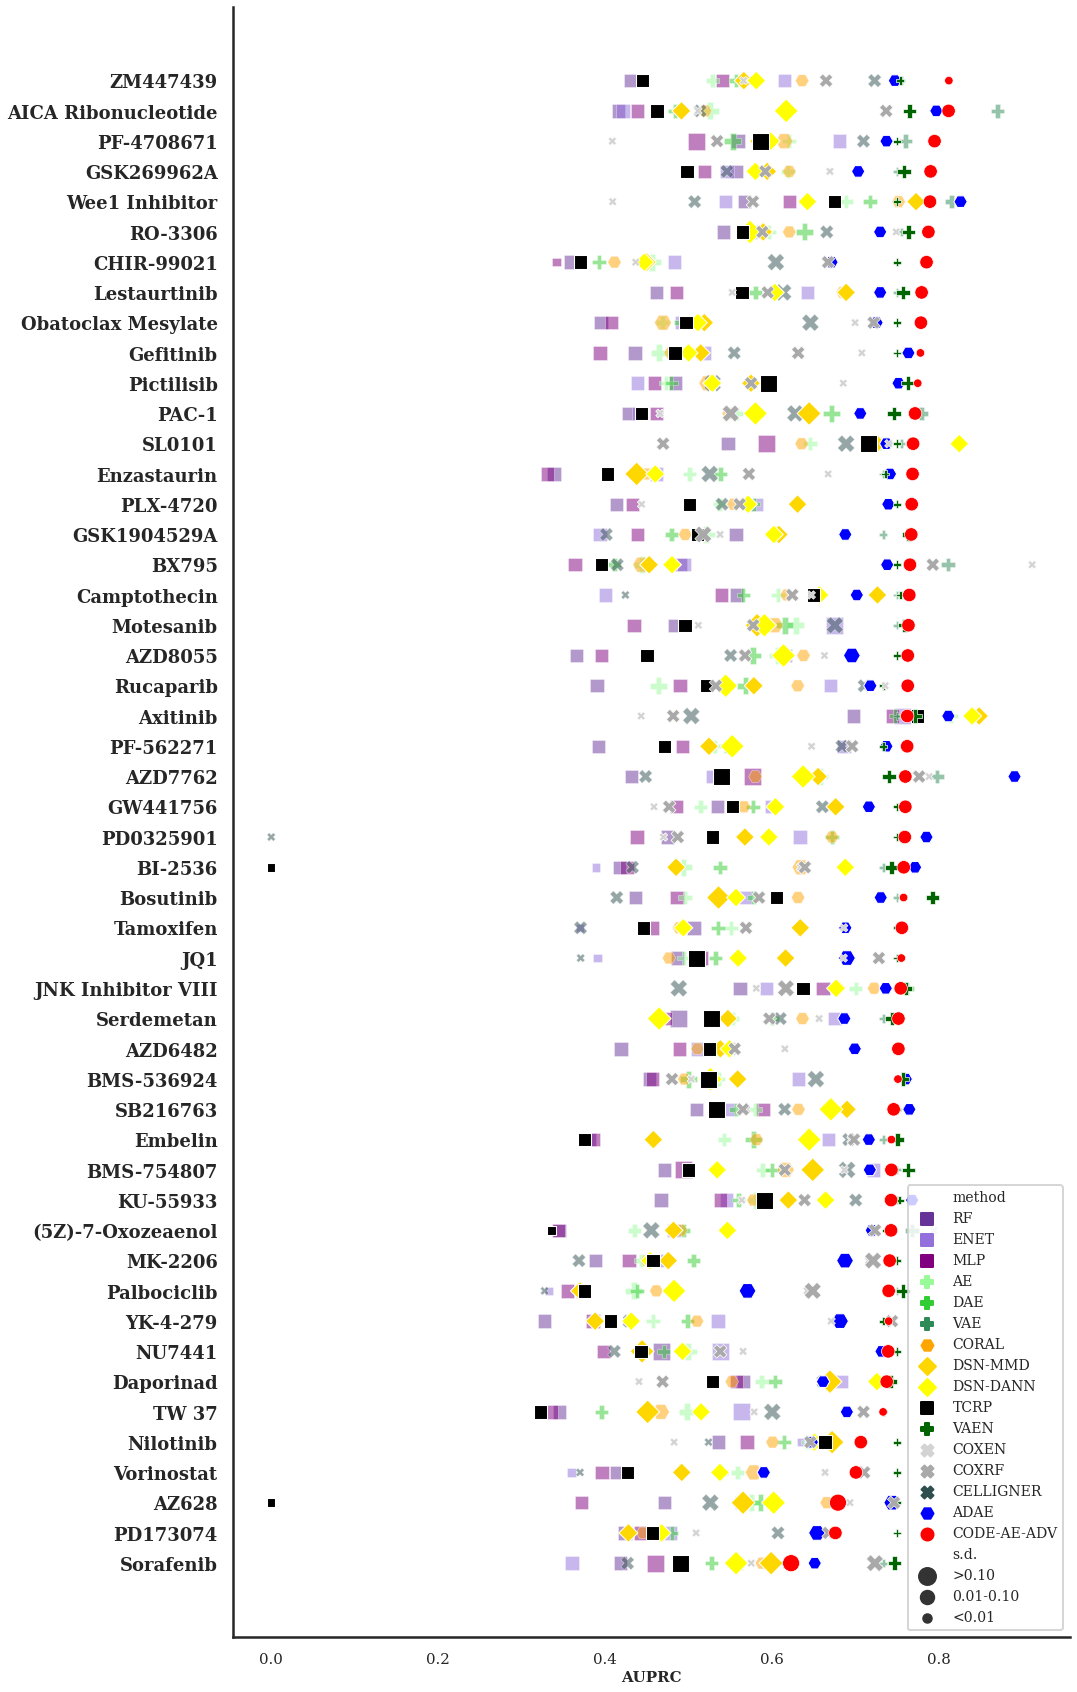

In [19]:
plt.figure(figsize=(15, 30))
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})
ax = sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                     alpha=0.5,
                     s=500,
                     palette=palette,
                     data=pdtc_plot_df[~pdtc_plot_df.method.isin(['CODE-AE-ADV', 'TCRP','VAEN','DSN-MMD','DSN-DANN','ADAE'])],
                    legend=True)
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['DSN-MMD','DSN-DANN','ADAE'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['TCRP'])],
                legend=False
               )
sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.', style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['VAEN', 'COXEN', 'COXRF'])],
                legend=False
               )

sns.scatterplot(x='mean_val', y='drug', hue='method', size='s.d.',style='method', markers=marker_dict,
                alpha=1.0,
                s=500,
                palette=palette,
                data=pdtc_plot_df[pdtc_plot_df.method.isin(['CODE-AE-ADV'])],
                legend=False
               )


sns.despine()
plt.ylabel('')
plt.xlabel('AUPRC', fontsize=15, weight='bold')
plt.yticks(fontsize=18, weight='bold')
plt.xticks(fontsize=15)
plt.legend(loc='lower right', fontsize=14)
#plt.savefig('../paper/pdtc_auprc.png', format='png', dpi=350,bbox_inches='tight')

## Chemotherapy Drug Response Prediction

In [20]:
def get_largest_kv(d, std_dict):
    k = max(d.items(), key=itemgetter(1))[0]
    return k, d[k], std_dict[k]

def parse_param_str(param_str):
    pattern = re.compile('(pretrain_num_epochs)?_?(\d+)?_?(train_num_epochs)_(\d+)_(dop)_(\d\.\d)')
    matches = pattern.findall(param_str)
    return {matches[0][i]: float(matches[0][i+1]) for i in range(0,len(matches[0]), 2) if matches[0][i] != ''}

def parse_ft_evaluation_result(file_name, method, category, measurement='AUC',metric_name='auroc',pdtc_flag=False,folder='../intermediate_results/plot_data/tcga/model_save'):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc/{category}'
    else:
        folder = f'{folder}/{method}/{measurement}/{category}'        
    with open(os.path.join(folder, file_name), 'r') as f:
        result_dict = json.load(f)
    if 'enet' in result_dict:
        result_dict = result_dict['enet'][0]
    return result_dict[metric_name]

In [21]:
import re
from collections import Counter

def parse_hyper_ft_evaluation_result(method, category, measurement='AUC',metric_name='auroc', pdtc_flag = False, folder='../intermediate_results/plot_data/tcga/model_save'):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc/{category}'
    else:
        folder = f'{folder}/{method}/{measurement}/{category}'        
    evaluation_metrics = {}
    evaluation_metrics_std = {}
    evaluation_metrics_count = {}
    count = 0
    for file in os.listdir(folder):
        if re.match('(pretrain|train)+.*(dop+).*(ft)+.*\.json', file) or file == 'ft_evaluation_results.json':
            count += 1
            with open(os.path.join(folder, file), 'r') as f:
                result_dict = json.load(f)
            
            if 'enet' in result_dict:
                result_dict = result_dict['enet'][0]
            
            evaluation_metrics[file] = np.mean(result_dict[metric_name])
            evaluation_metrics_std[file] = np.std(result_dict[metric_name])
            evaluation_metrics_count[file] = len(Counter(result_dict[metric_name]))/len(result_dict[metric_name])
    to_exclude = []
    for k, v in evaluation_metrics_count.items():
        if v < 0.4: 
            to_exclude.append(k)
            
    if len(to_exclude)>0:
        for k in to_exclude:
            evaluation_metrics.pop(k)
            evaluation_metrics_std.pop(k)
                    
    return evaluation_metrics, evaluation_metrics_std, count
            

In [22]:
def generate_hyper_ft_report(metric_name='auroc', measurement='AUC', pdtc_flag=False, folder='../intermediate_results/plot_data/tcga/model_save'):
    methods = ['enet','rf', 'cell_enet', 'mlp','ae','dae', 'vae','vaen','coxen','coxrf','coral', 'adae','tcrp','dsna','dsn','adsn_norm']
    #methods = ['ndsn', 'mdsn','adsn', 'ndsn_norm', 'mdsn_norm','ndsn_concat', 'adsn_norm','mdsn_concat','adsn_concat','ndsn_norm_concat', 'mdsn_norm_concat','adsn_norm_concat']
    if pdtc_flag:
        categories = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0).index.tolist()
    else:    
        categories = ['tgem', 'tfu','tem', 'gem', 'cis', 'sor', 'fu']

    #categories = ['female', 'male']
    
    report = pd.DataFrame(np.full((len(methods), len(categories)),fill_value=0.5), index=methods, columns=categories)
    report_std = pd.DataFrame(np.zeros((len(methods), len(categories))), index=methods, columns=categories)
    result_dict = defaultdict(dict)

    for cat in categories:
        for method in methods:
            #print(f'{method}: {cat}')
            folder = f'{folder}/{method}'
            try:
                param_str, report.loc[method, cat], report_std.loc[method, cat] = get_largest_kv(d = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag)[0],
                                                                                                std_dict = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag)[1])
                if method in ['enet', 'rf', 'cell_enet']:
                    result_dict[cat][method] = parse_ft_evaluation_result(file_name = 'ft_evaluation_results.json', method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag)
                else:
                    result_dict[cat][method] = parse_ft_evaluation_result(file_name = param_str, 
                                                                          method=method, category=cat, 
                                                                          metric_name=metric_name, 
                                                                          measurement=measurement, 
                                                                          pdtc_flag=pdtc_flag)

            except Exception as e:
                print(e)

                
    return report, report_std, result_dict


In [23]:
auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_hyper_ft_report(metric_name='auroc', measurement='AUC')

max() arg is an empty sequence
max() arg is an empty sequence


In [24]:
#average rank when predict chemotherapy prediction on relapses after treatment
auc_ft_report[['tem','gem','cis','sor','fu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         11.0
rf           13.6
cell_enet    11.8
mlp          12.2
ae            6.4
dae           8.2
vae           8.6
vaen          4.6
coxen        10.2
coxrf        12.2
coral         6.8
adae          5.2
tcrp         11.4
dsna          6.0
dsn           6.0
adsn_norm     1.6
dtype: float64

In [25]:
#average rank when predict chemotherapy prediction on clinical diagnosis
auc_ft_report[['tgem','tfu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         11.0
rf           14.0
cell_enet    13.5
mlp           6.0
ae            6.0
dae           3.0
vae          10.5
vaen         12.0
coxen        13.5
coxrf        16.0
coral         7.5
adae          4.0
tcrp          9.0
dsna          5.0
dsn           4.0
adsn_norm     1.0
dtype: float64

In [26]:
#average rank when predict chemotherapy prediction overall
auc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)


enet         11.000000
rf           13.714286
cell_enet    12.285714
mlp          10.428571
ae            6.285714
dae           6.714286
vae           9.142857
vaen          6.714286
coxen        11.142857
coxrf        13.285714
coral         7.000000
adae          4.857143
tcrp         10.714286
dsna          5.714286
dsn           5.428571
adsn_norm     1.428571
dtype: float64

In [27]:
auc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)


enet         3.696846
rf           1.112697
cell_enet    4.347961
mlp          3.207135
ae           2.058663
dae          3.199702
vae          1.676163
vaen         4.923220
coxen        6.743604
coxrf        3.147183
coral        2.943920
adae         2.410295
tcrp         3.251373
dsna         1.799471
dsn          3.779645
adsn_norm    0.534522
dtype: float64

In [28]:
drug_mapping = pd.read_csv('../data/tcga_gdsc_drug_mapping.csv', index_col=0)

drug_dict = drug_mapping['gdsc_name'].to_dict()
drug_dict['tgem'] = 'Gemcitabine (diagnosis)'
drug_dict['tfu'] = '5-Fluorouracil (diagnosis)'

result_df = None
for cat in ['tgem', 'tfu', 'fu','tem', 'cis', 'sor', 'gem']:
    temp_df = pd.DataFrame.from_dict(auc_ft_result_dict[cat])
    temp_df = temp_df.rename(columns={'tcrp': 'TCRP', 'cell_enet':'CELLIGNER','dsn':"dsn-mmd", 'dsna': 'dsn-dann', 'adsn_norm': 'code-ae-adv'})
    temp_df = temp_df.rename(columns={k: k.upper() for k in temp_df.columns})

    temp_df = pd.melt(temp_df)
    temp_df['drug'] = drug_dict[cat]
    temp_df['metric'] = 'AUC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auroc'})
method_order = ['RF','ENET','MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN','COXRF','CELLIGNER','ADAE','CODE-AE-ADV']
result_df.method = result_df.method.astype('category')
result_df.method.cat.set_categories(method_order, inplace=True)
result_df.sort_values(by='method', inplace=True)

drug_order = ['5-Fluorouracil (diagnosis)', '5-Fluorouracil', 'Temozolomide', 'Sorafenib','Gemcitabine (diagnosis)','Gemcitabine', 'Cisplatin']
result_df.drug = result_df.drug.astype('category')
result_df.drug.cat.set_categories(drug_order, inplace=True)
result_df.sort_values(by='drug', inplace=True)


<Figure size 1080x720 with 0 Axes>

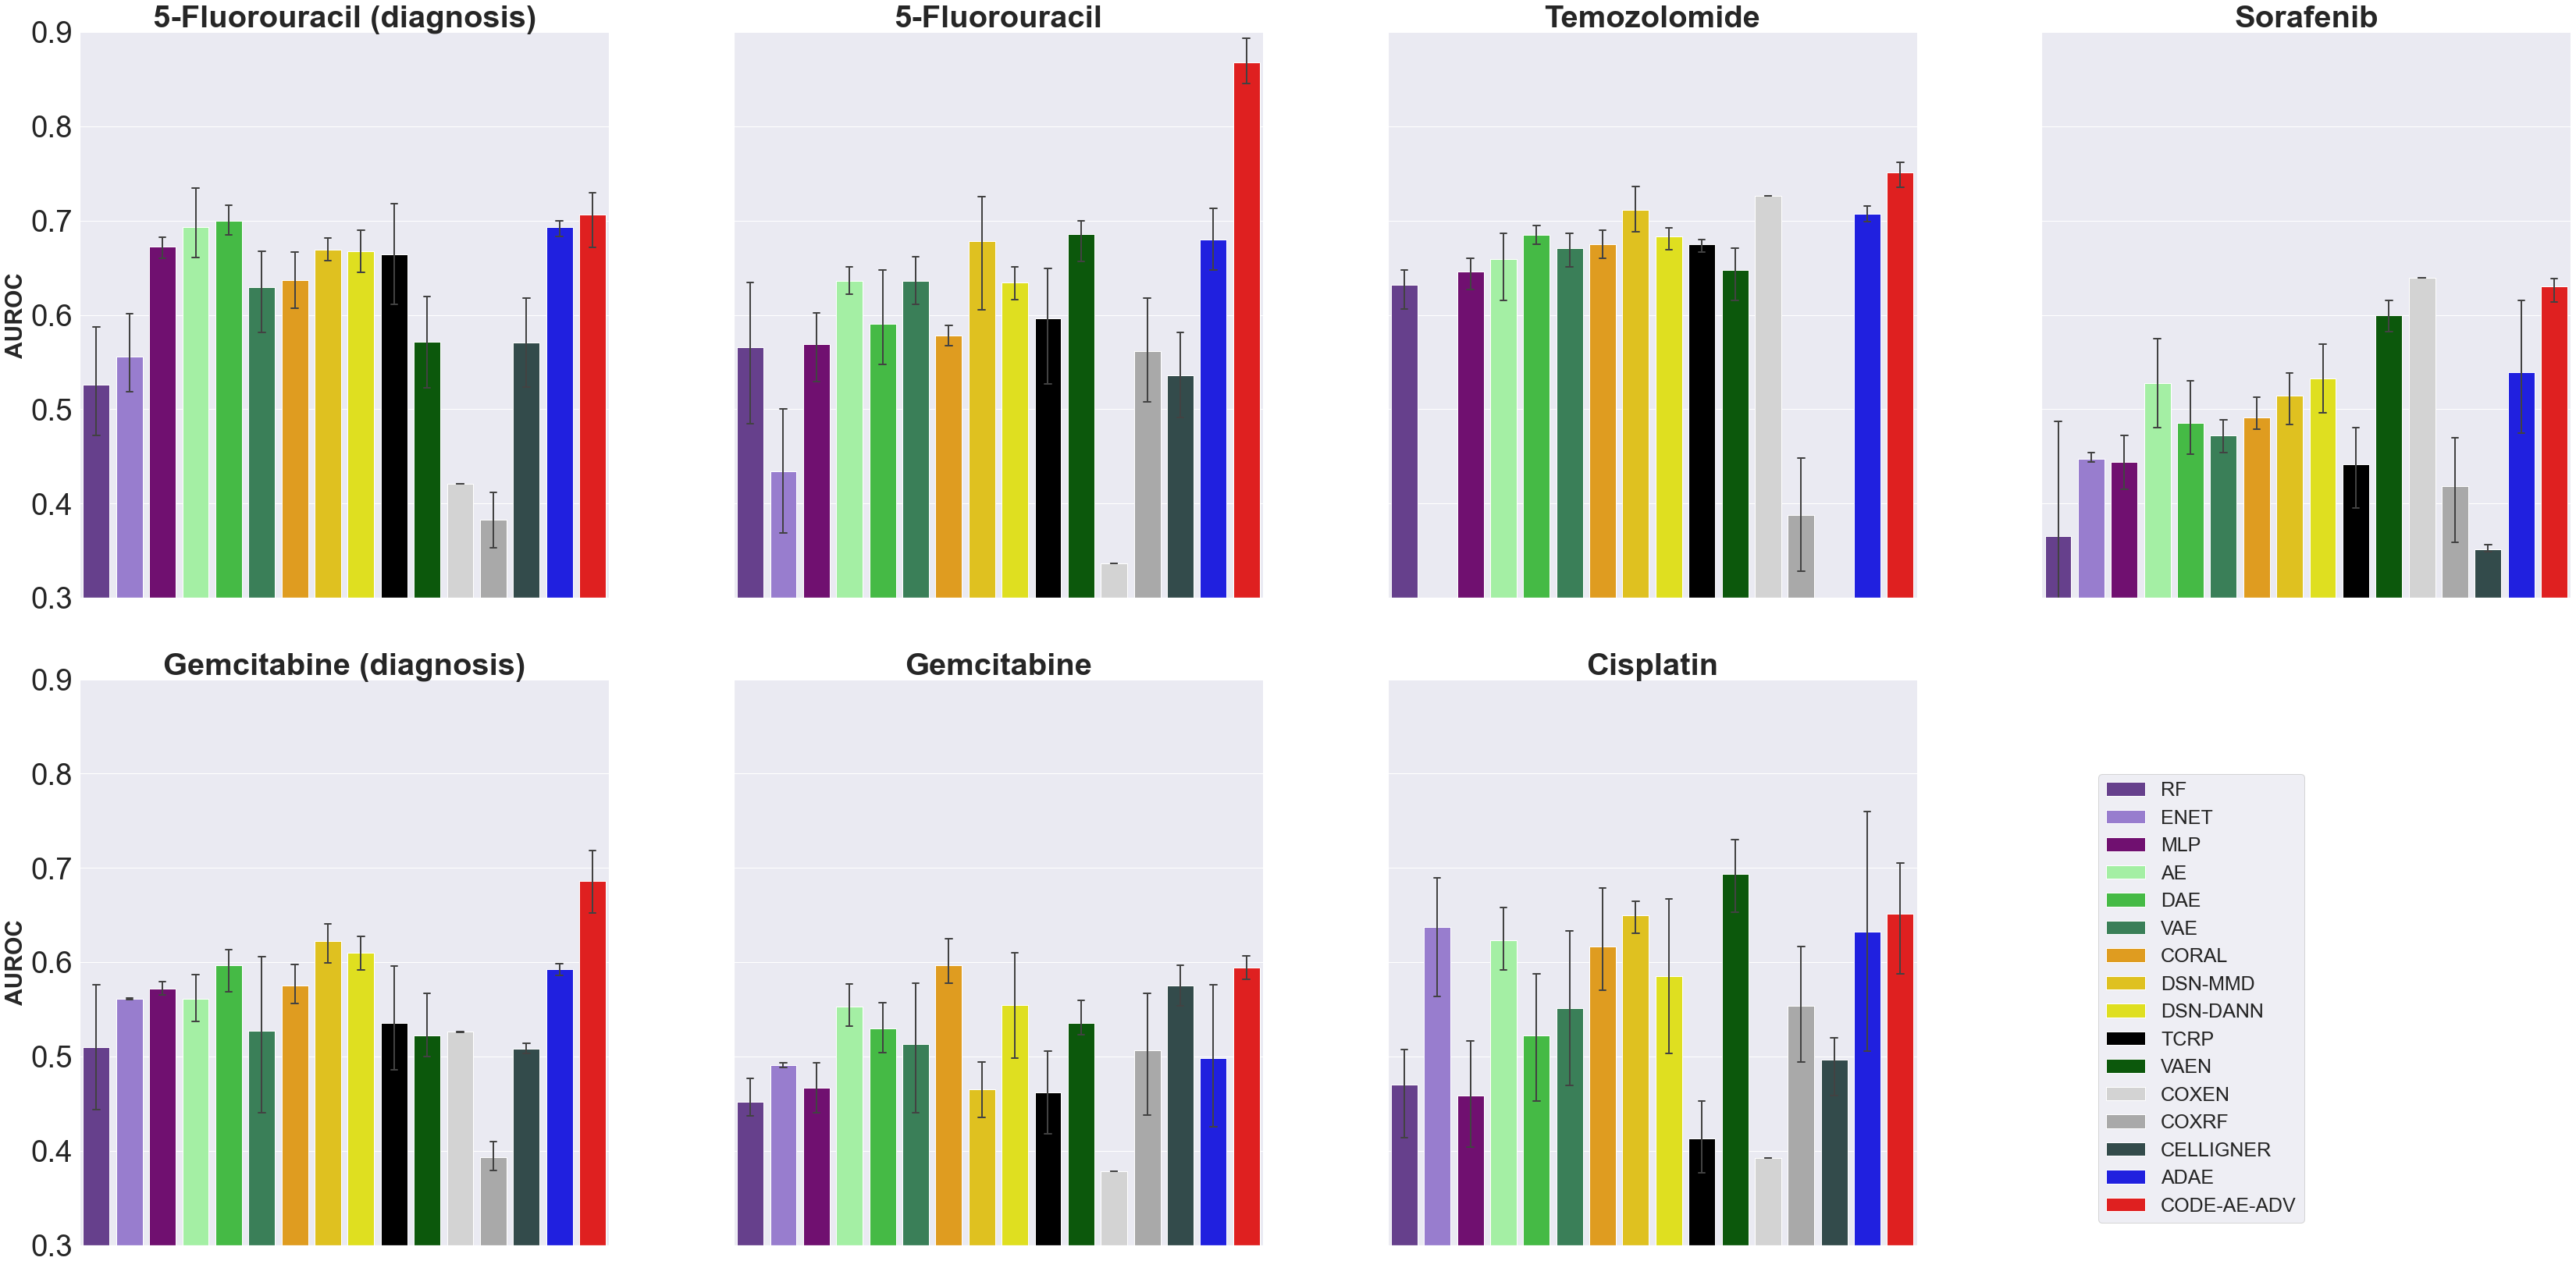

In [29]:
plt.figure(figsize=(15, 10))
sns.set(font_scale = 3.5)
g= sns.FacetGrid(result_df.loc[result_df.metric=='AUC'], col="drug", col_wrap=4, height=12)
g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=40, weight='bold')
g.set(ylim=(0.3,0.9))
g.set_xlabels('')
g.set_ylabels('AUROC', size=30, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=25)
#plt.savefig('../paper/tcga_auc_bar.png', format='png', dpi=350,bbox_inches='tight')

In [30]:
## check p vals
print('Gemcitabine (diagnosis)', generate_p_val(a=auc_ft_result_dict['tgem']['adsn_norm'], b=auc_ft_result_dict['tgem']['dsn']))
print('5-Fluorouracil (diagnosis)', generate_p_val(a=auc_ft_result_dict['tfu']['adsn_norm'], b=auc_ft_result_dict['tfu']['dae']))
print('5-Fluorouracil', generate_p_val(a=auc_ft_result_dict['fu']['adsn_norm'], b=auc_ft_result_dict['fu']['dsn']))
print('Temozolomide', generate_p_val(a=auc_ft_result_dict['tem']['adsn_norm'], b=auc_ft_result_dict['tem']['coxen']))
print('Sorafenib', generate_p_val(a=auc_ft_result_dict['sor']['adsn_norm'], b=auc_ft_result_dict['sor']['coxen']))
print('Gemcitabine', generate_p_val(a=auc_ft_result_dict['gem']['adsn_norm'], b=auc_ft_result_dict['gem']['coral']))
print('Cisplatin', generate_p_val(a=auc_ft_result_dict['cis']['adsn_norm'], b=auc_ft_result_dict['cis']['vaen']))

ttest_ind:            t = 2.76614  p = 0.0289969
Gemcitabine (diagnosis) None
ttest_ind:            t = 0.325404  p = 0.755977
5-Fluorouracil (diagnosis) None
ttest_ind:            t = 5.28742  p = 0.00277022
5-Fluorouracil None
ttest_ind:            t = 3.31203  p = 0.0295982
Temozolomide None
ttest_ind:            t = -1.0308  p = 0.360879
Sorafenib None
ttest_ind:            t = -0.164713  p = 0.874624
Gemcitabine None
ttest_ind:            t = -1.09289  p = 0.310245
Cisplatin None


### AUPRC

In [31]:
auprc_ft_report, auprc_ft_report_std, auprc_ft_result_dict = generate_hyper_ft_report(metric_name='auprc', measurement='AUPRC')

max() arg is an empty sequence
max() arg is an empty sequence


In [32]:
#average rank when predict chemotherapy prediction on relapses after treatment
auprc_ft_report[['tem','gem','cis','sor','fu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         11.0
rf           13.2
cell_enet    12.6
mlp          11.4
ae            9.0
dae           8.8
vae           7.6
vaen          2.4
coxen        11.2
coxrf        11.4
coral         6.6
adae          2.8
tcrp         12.2
dsna          6.2
dsn           7.4
adsn_norm     2.0
dtype: float64

In [33]:
#average rank when predict chemotherapy prediction on clinical diagnosis
auprc_ft_report[['tgem','tfu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet          9.5
rf           14.5
cell_enet    10.0
mlp          11.0
ae            8.0
dae           6.5
vae           6.0
vaen          3.0
coxen        11.0
coxrf        16.0
coral        11.0
adae          3.0
tcrp         12.0
dsna          7.5
dsn           5.5
adsn_norm     1.5
dtype: float64

In [34]:
#average rank when predict chemotherapy prediction overall
auprc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)


enet         10.571429
rf           13.571429
cell_enet    11.857143
mlp          11.285714
ae            8.714286
dae           8.142857
vae           7.142857
vaen          2.571429
coxen        11.142857
coxrf        12.714286
coral         7.857143
adae          2.857143
tcrp         12.142857
dsna          6.571429
dsn           6.857143
adsn_norm     1.857143
dtype: float64

In [35]:
auprc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)


enet         3.866831
rf           1.902379
cell_enet    3.848314
mlp          2.214670
ae           2.627691
dae          2.911390
vae          3.804759
vaen         1.812654
coxen        5.871643
coxrf        3.450328
coral        2.911390
adae         0.899735
tcrp         2.115701
dsna         2.225395
dsn          3.976119
adsn_norm    0.899735
dtype: float64

In [36]:
result_df = None
for cat in ['tgem', 'tfu', 'fu','tem', 'cis', 'sor', 'gem']:
    temp_df = pd.DataFrame.from_dict(auprc_ft_result_dict[cat])
    temp_df = temp_df.rename(columns={'tcrp': 'TCRP','cell_enet':'CELLIGNER','dsn':"dsn-mmd", 'dsna': 'dsn-dann', 'adsn_norm': 'code-ae-adv'})
    temp_df = temp_df.rename(columns={k: k.upper() for k in temp_df.columns})

    temp_df = pd.melt(temp_df)
    temp_df['drug'] = drug_dict[cat]
    temp_df['metric'] = 'AUPRC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auprc'})
method_order = ['RF','ENET','MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN','COXRF', 'CELLIGNER','ADAE','CODE-AE-ADV']
result_df.method = result_df.method.astype('category')
result_df.method.cat.set_categories(method_order, inplace=True)
result_df.sort_values(by='method', inplace=True)

drug_order = ['5-Fluorouracil (diagnosis)', '5-Fluorouracil', 'Temozolomide', 'Sorafenib','Gemcitabine (diagnosis)','Gemcitabine', 'Cisplatin']
result_df.drug = result_df.drug.astype('category')
result_df.drug.cat.set_categories(drug_order, inplace=True)
result_df.sort_values(by='drug', inplace=True)


<Figure size 1080x720 with 0 Axes>

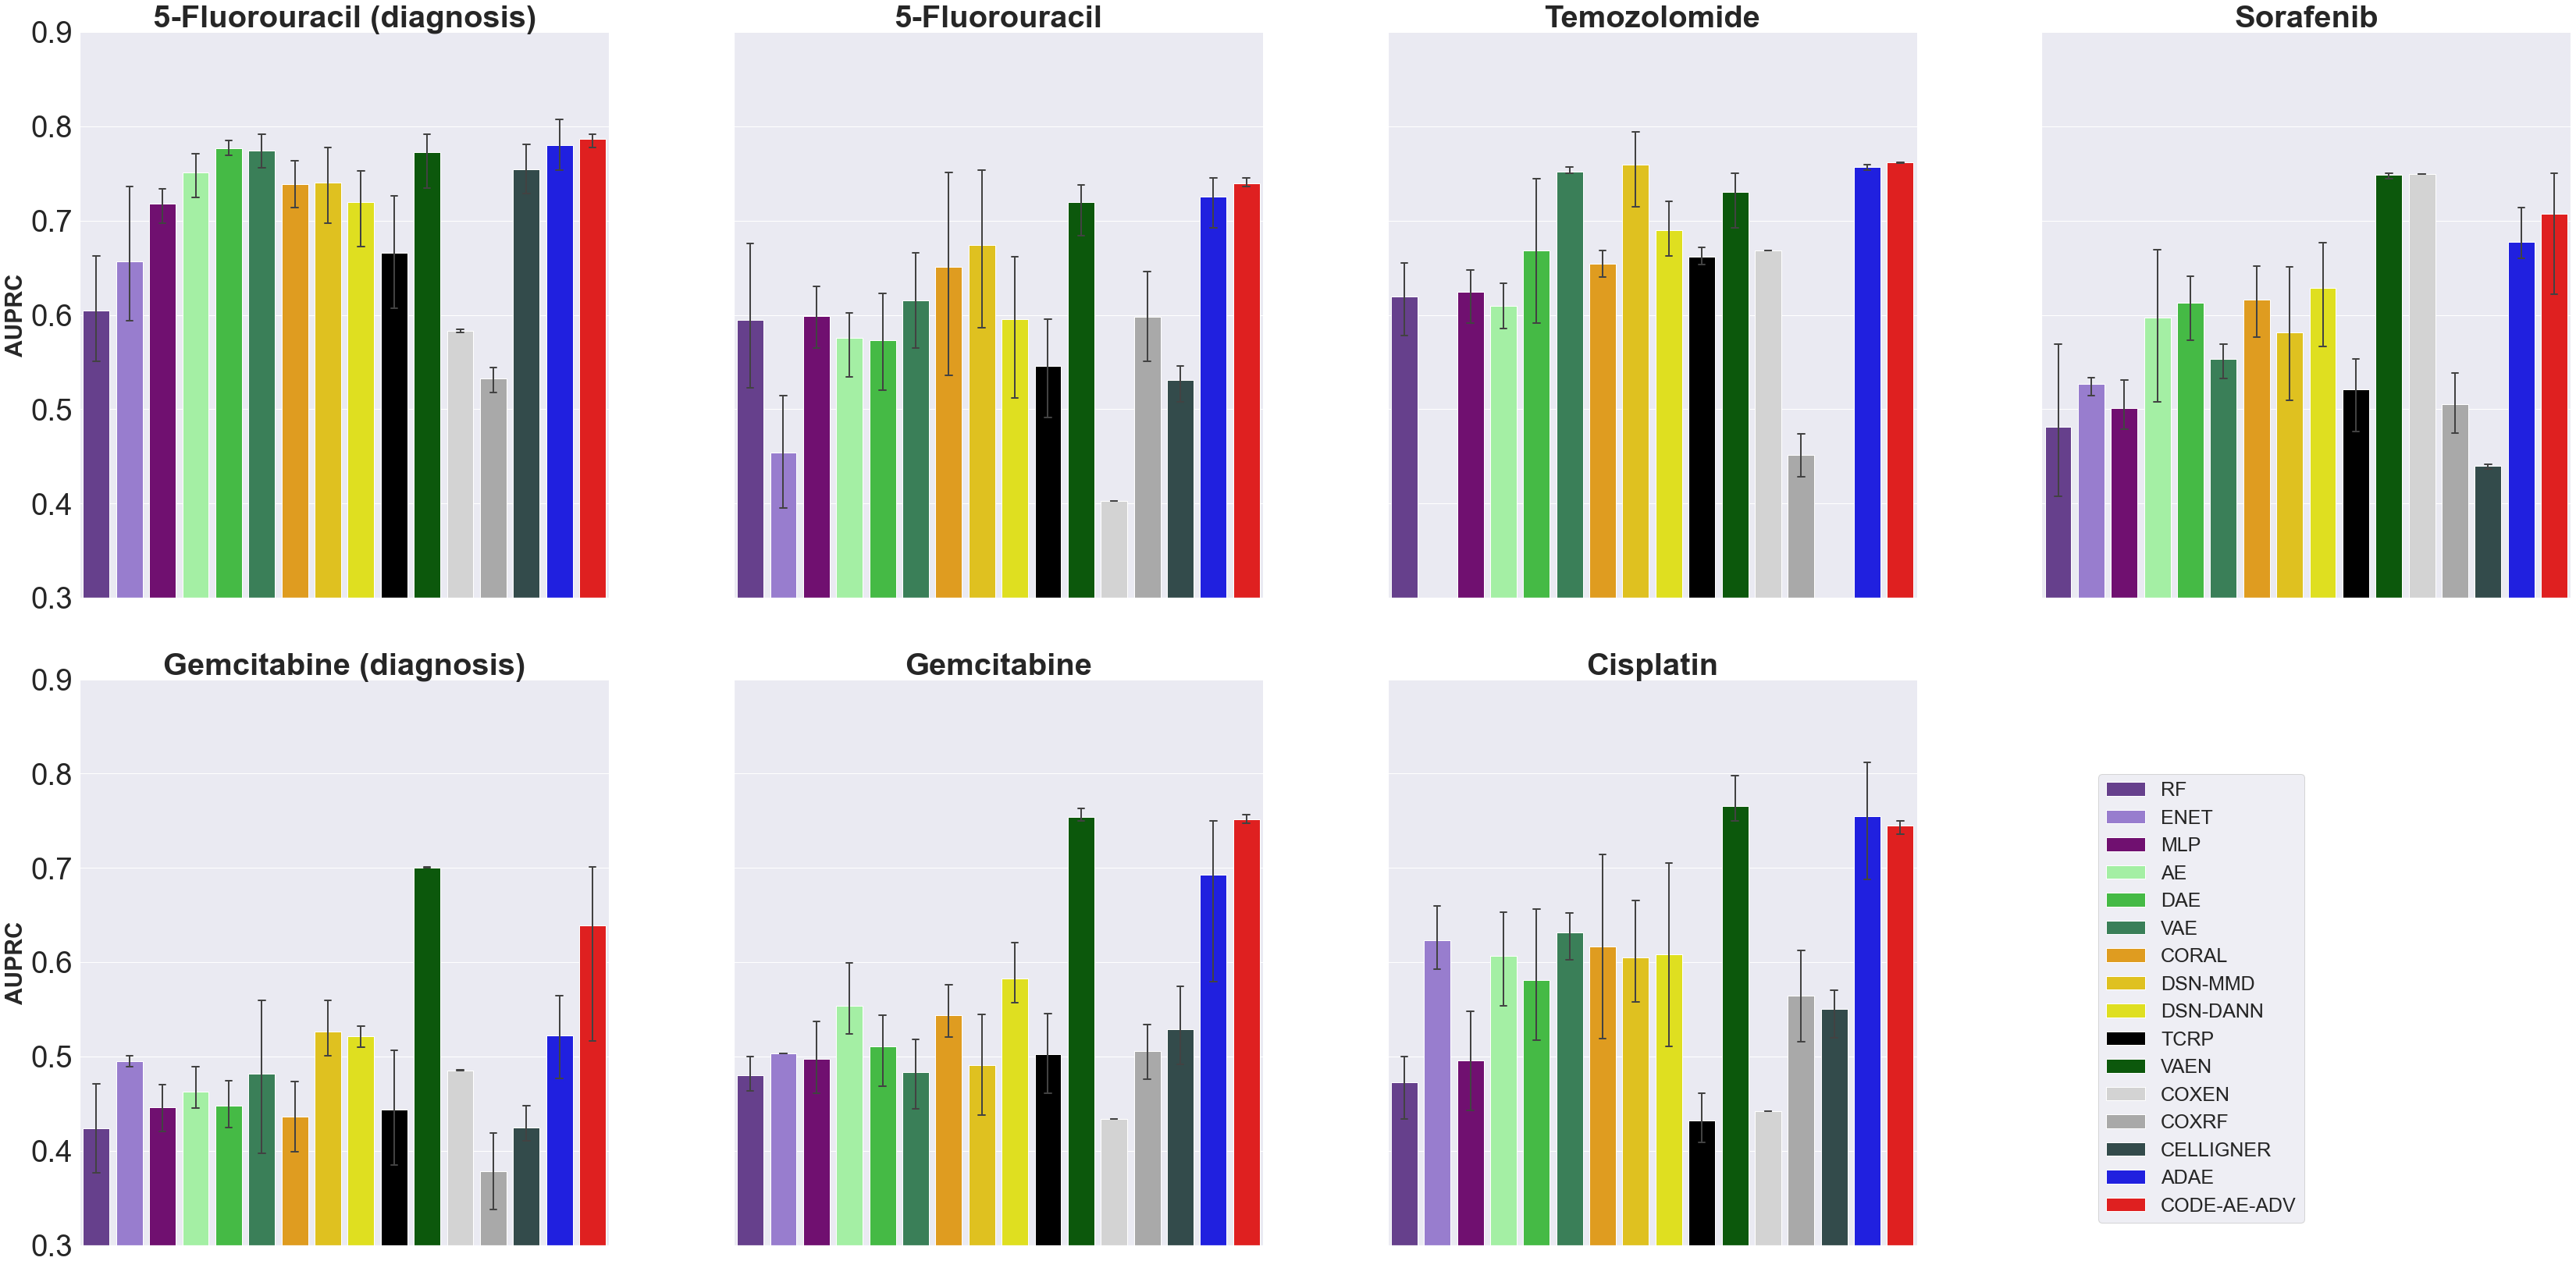

In [37]:
plt.figure(figsize=(15, 10))
sns.set(font_scale = 3.5)
g= sns.FacetGrid(result_df.loc[result_df.metric=='AUPRC'], col="drug", col_wrap=4, height=12)
g.map_dataframe(sns.barplot, x='method', y='auprc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=40, weight='bold')
g.set(ylim=(0.3,0.9))
g.set_xlabels('')
g.set_ylabels('AUPRC', size=30, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=25)
#plt.savefig('../paper/tcga_auprc_bar.png', format='png', dpi=350,bbox_inches='tight')

In [38]:
## check p vals
print('Gemcitabine (diagnosis)', generate_p_val(a=auc_ft_result_dict['tgem']['adsn_norm'], b=auc_ft_result_dict['tgem']['adae']))
print('5-Fluorouracil (diagnosis)', generate_p_val(a=auc_ft_result_dict['tfu']['adsn_norm'], b=auc_ft_result_dict['tfu']['adae']))
print('5-Fluorouracil', generate_p_val(a=auc_ft_result_dict['fu']['adsn_norm'], b=auc_ft_result_dict['fu']['vaen']))
print('Temozolomide', generate_p_val(a=auc_ft_result_dict['tem']['adsn_norm'], b=auc_ft_result_dict['tem']['adae']))
print('Sorafenib', generate_p_val(a=auc_ft_result_dict['sor']['adsn_norm'], b=auc_ft_result_dict['sor']['vaen']))
print('Gemcitabine', generate_p_val(a=auc_ft_result_dict['gem']['adsn_norm'], b=auc_ft_result_dict['gem']['vaen']))
print('Cisplatin', generate_p_val(a=auc_ft_result_dict['cis']['adsn_norm'], b=auc_ft_result_dict['cis']['vaen']))

ttest_ind:            t = 4.73614  p = 0.00765258
Gemcitabine (diagnosis) None
ttest_ind:            t = 0.699231  p = 0.518632
5-Fluorouracil (diagnosis) None
ttest_ind:            t = 9.21955  p = 1.62643e-05
5-Fluorouracil None
ttest_ind:            t = 4.94461  p = 0.0020183
Temozolomide None
ttest_ind:            t = 2.42565  p = 0.0419999
Sorafenib None
ttest_ind:            t = 4.27548  p = 0.00446134
Gemcitabine None
ttest_ind:            t = -1.09289  p = 0.310245
Cisplatin None


### tSNE plots for difference features

In [192]:
tsne = manifold.TSNE(n_components=2, init='random',random_state=0)


In [201]:
ori_gex = pd.read_csv('../data/preprocessed_dat/uq1000_feature.csv', index_col=0)
gex_label = ['TCGA'] * 9808 + ['CCLE']*1305


In [202]:
ori_gex_y = tsne.fit_transform(ori_gex)

In [205]:
ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
ori_encoder_feature_df['Sample'] = gex_label

Text(0.5, 1.0, 'Original')

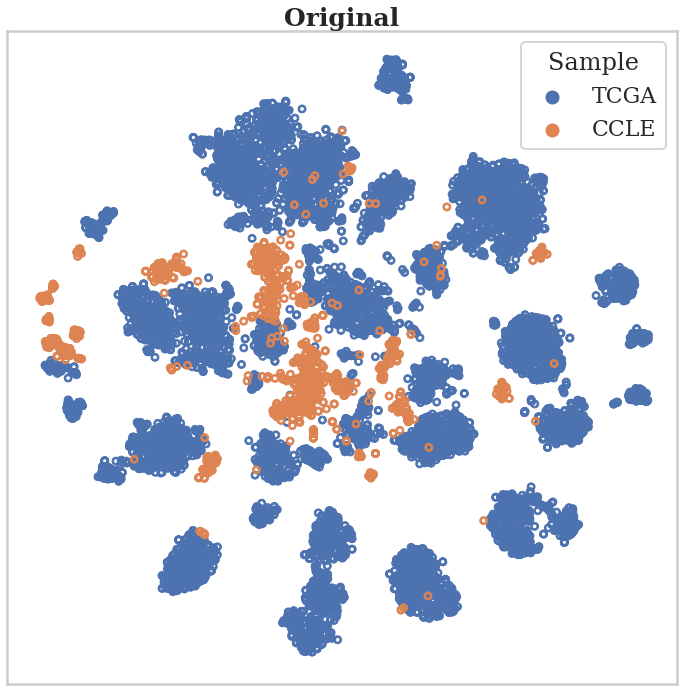

In [208]:
plt.figure(figsize=(12,12))
sns.set(font_scale = 2.0)
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


ax = sns.scatterplot(x='x',y='y',data=ori_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('Original', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/Original_tSNE.png', format='png', dpi=350,bbox_inches='tight')


In [209]:
ccle_gex = pd.read_csv(f'../intermediate_results/encoded_features/ae_ccle_features.csv',index_col=0)
tcga_gex = pd.read_csv(f'../intermediate_results/encoded_features/ae_tcga_features.csv',index_col=0)
ae_all_gex = pd.concat([tcga_gex, ccle_gex])
ae_all_gex_y = tsne.fit_transform(ae_all_gex)


    

Text(0.5, 1.0, 'AE')

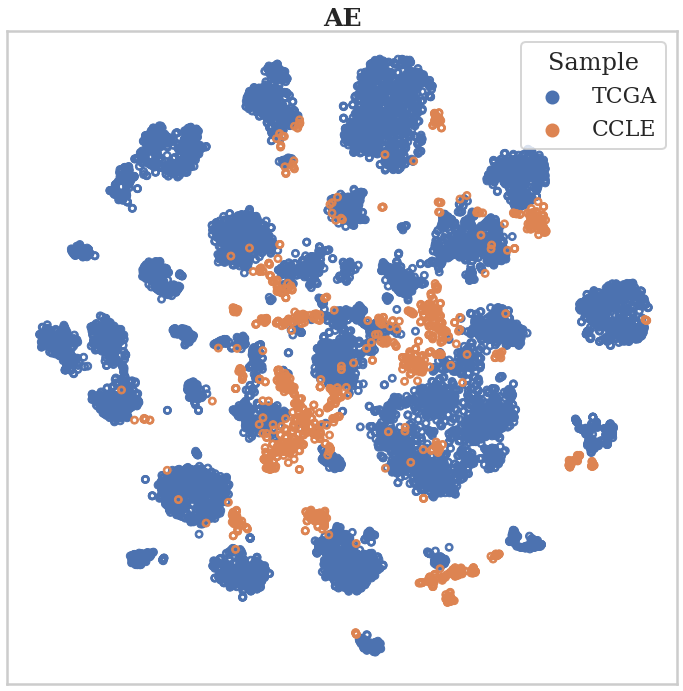

In [211]:
ae_encoder_feature_df = pd.DataFrame(ae_all_gex_y, columns=['x','y'])
ae_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax = sns.scatterplot(x='x',y='y',data=ae_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('AE', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/AE_tSNE.png', format='png', dpi=350,bbox_inches='tight')


In [212]:
ccle_gex = pd.read_csv(f'../intermediate_results/encoded_features/codeae_ccle_features.csv',index_col=0)
tcga_gex = pd.read_csv(f'../intermediate_results/encoded_features/codeae_tcga_features.csv',index_col=0)
codeae_all_gex = pd.concat([tcga_gex, ccle_gex])
codeae_all_gex_y = tsne.fit_transform(codeae_all_gex)


    

Text(0.5, 1.0, 'AE')

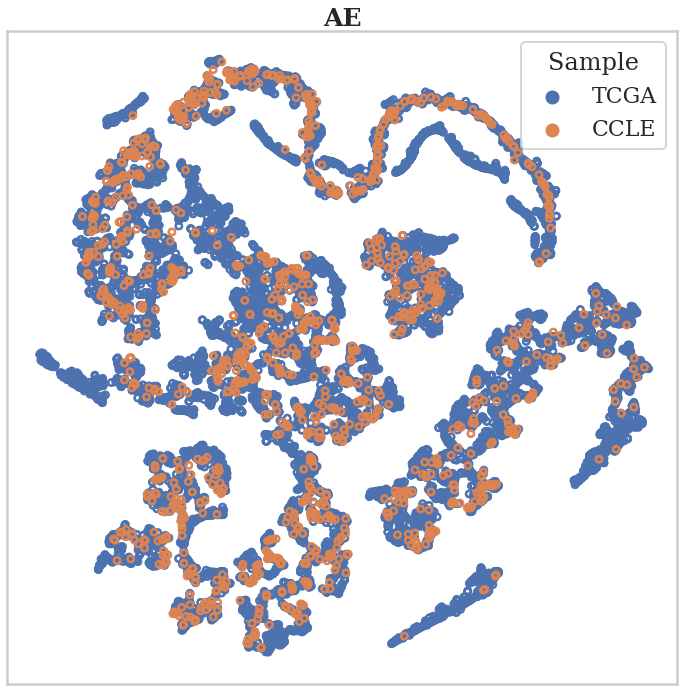

In [213]:
codeae_encoder_feature_df = pd.DataFrame(codeae_all_gex_y, columns=['x','y'])
codeae_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax = sns.scatterplot(x='x',y='y',data=codeae_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('AE', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/CODEAE_tSNE.png', format='png', dpi=350,bbox_inches='tight')
